In [5]:
!pip install evaluate

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score
from scipy.special import softmax
import matplotlib.pyplot as plt
import os

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9993"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [2]:
df1 = pd.read_csv('positive_sequences.csv')
df2 = pd.read_csv('negative_sequences.csv')
df1.shape

(11981, 3)

In [3]:
neg = df2.sample(frac=0.1, random_state=950806)
neg.shape

(14772, 4)

In [5]:
df2.head()

,Unnamed: 0,heavy_sequence,light_sequence,targets_mentioned
0,0,EVQLVESGGGVVQAGTSLRLSCTASAFNLSDYAMHWVRQAPGKGLZ...,ESALTZPRSVSGSPGHSVTISCIGTSSNVGDYKYVSWYZZHPGKAP...,NaN
1,1,QVKLQESGAELVKPGASVKLSCTTSGFNIKDTYMHWVKQRPEQGLE...,DIELTQSPAIMSASLGEKVTMSCRASSSVNFIYWYQQKSDASPKLW...,digoxin
2,2,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,NaN
3,3,QVQLKQSGPGLVQPSQSLSITCTVSGFSLTTYGVHWIRQSPGKGLE...,DIKMTQSPSSMYASLGERVTVTCKASQDINSYLSWIQQKPGKSPKT...,NaN
4,4,DVKLVESGGDLVKLGGSLKLSCAASGFTFSSYYMSWVRQISEKRLE...,NIVLTQSPASLAVSLGQRATISCRASESVDSYDNSFMHWYQQKPGQ...,NaN


In [6]:
df1['label'] = 1
neg['label'] = 0
combined_df = pd.concat([df1, neg])

In [11]:
combined_df[['heavy_sequence', 'label']].head()

,heavy_sequence,label
0,EVQLVESGGGLIQPGGSLRLSCAASGFIVSRNYMNWVRQAPGKGLE...,1
1,QVQMVESGGGLVRPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLE...,1
2,QVQLVESGGGVVQPGRSLRLSCASSGFTFSTYHMHWVRQPPGKGLE...,1
3,EVQLVESGGGLIQPGGSLRLSCAVSGFTVSRMSWVRQAPGKGLECV...,1
4,EVQLVESGGGLIQPGGSLRLSCAASEFIVSRNYMSWVRQAPGKGLE...,1


# ProtTrans Fine Tuning Code

In [10]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [11]:
class ClassConfig:
    def __init__(self, dropout=0.2, num_labels=1):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [12]:
def PT5_classification_model(num_labels, half_precision):
    # Load PT5 and tokenizer
    # possible to load the half preciion model (thanks to @pawel-rezo for pointing that out)
    if not half_precision:
        config = T5Config.from_pretrained("Rostlab/prot_t5_xl_uniref50", output_hidden_states=True)
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50", config=config)
        tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    elif half_precision and torch.cuda.is_available() : 
        tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16).to(torch.device('cuda'))
    else:
          raise ValueError('Half precision can be run on GPU only.')
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Transformer Model\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig()
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Model_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [13]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [14]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=256, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset
    
# Main training fuction
def train_per_protein(
        train_df,         #training data
        valid_df,         #validation data      
        num_labels= 1,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs= 10,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed= True,  #if gpu is large enough disable deepspeed for training speedup
        mixed= False,     #enable mixed precision training
        gpu= 1 ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, half_precision=False)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Add spaces between each amino acid for PT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
        fp16 = mixed,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        if num_labels>1:  # for classification
            metric = load("accuracy")
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
        else:  # for regression
            metric = load("spearmanr")
            predictions, labels = eval_pred

        return metric.compute(predictions=predictions, references=labels)
    
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )    
    
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history

In [14]:
pos = df1[['heavy_sequence', 'label']]
neg = neg[['heavy_sequence', 'label']]
combined = pd.concat([pos, neg])
combined.columns = ["sequence","label"]
# combined['label'] = combined['label'].astype(float)

In [15]:
len(combined)

26753

In [16]:
my_train, temp_data = train_test_split(combined, test_size=0.2, random_state=950806)

# Step 2: Split the temporary data into validation and testing sets (50% for validation, 50% for testing)
my_valid, my_test = train_test_split(temp_data, test_size=0.5, random_state=950806)

# Print the sizes of the resulting sets
print("Training set size:", len(my_train))
print("Validation set size:", len(my_valid))
print("Testing set size:", len(my_test))

Training set size: 21402
Validation set size: 2675
Testing set size: 2676


In [17]:
max_length = 0

# Iterate over each sequence in the 'heavy_sequence' column
for sequence in combined['sequence']:
    # Calculate the length of the current sequence
    sequence_length = len(sequence)
    # Update max_length if the current sequence is longer
    if sequence_length > max_length:
        max_length = sequence_length

# Print the longest length
print("Longest length of sequences:", max_length)

Longest length of sequences: 226


In [18]:
my_train.head()

,sequence,label
2713,QVQLQESGPGLVKPSGTLSLTCAVSGGSISSSNWWSWVRQPPGKGL...,1
780,NRFGAILGLRLKKPGSSVKVSCKASGGTFSNYAINWVRQAPGQGLE...,1
109378,QVQLKQSGPGRVQPSQSLSITCTVSGFSLTSNGVVHWVRQSPGKGL...,0
72176,EVQLVQSGAEVKKPGESLKISCKGSGYSFTSYWIGWVRQMPGKGLE...,0
13817,EVQLVESGGGLVQPGGSLRLSCAVSGFTFSSYAMSWVRQAPGKGLE...,0


In [18]:
tokenizer, model, history = train_per_protein(my_train, my_valid, num_labels=2, batch=4, accum=2, epochs=8, seed=950806)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Transformer Model
Trainable Parameter: 1209193474
Model_LoRA_Classfier
Trainable Parameter: 3559426

[2024-04-12 01:29:49,988] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2024-04-12 01:29:50,221] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-04-12 01:29:50,221] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
Installed CUDA version 12.3 does not match the version torch was compiled with 12.1 but since the APIs are compatible, accepting this combination


Using /home/raylab/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Creating extension directory /home/raylab/.cache/torch_extensions/py311_cu121/cpu_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/raylab/.cache/torch_extensions/py311_cu121/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/4] /usr/local/cuda-12/bin/nvcc --generate-dependencies-with-compile --dependency-output custom_cuda_kernel.cuda.o.d -DTORCH_EXTENSION_NAME=cpu_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/raylab/anaconda3/lib/python3.11/site-packages/deepspeed/ops/csrc/includes -I/usr/local/cuda-12/include -isystem /home/raylab/anaconda3/lib/python3.11/site-packages/torch/include -isystem /home/raylab/anaconda3/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/raylab/anaconda3/lib/python3.11/site-packages/torch/include/TH -isystem /home/raylab/anaconda3/lib/python3.11/site-packages/torch/include/THC -isystem /usr/local/cuda-12/include -isystem /home/raylab/anaconda3/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode

Loading extension module cpu_adam...


Epoch,Training Loss,Validation Loss,Accuracy
0,0.479100,0.358433,0.847850
2,0.391700,0.352298,0.848224
2,0.352000,0.295856,0.884860
4,0.327100,0.297520,0.889346
4,0.303800,0.280978,0.890093
6,0.281700,0.284553,0.890093
6,0.266700,0.334304,0.872897
7,0.249600,0.265979,0.893084


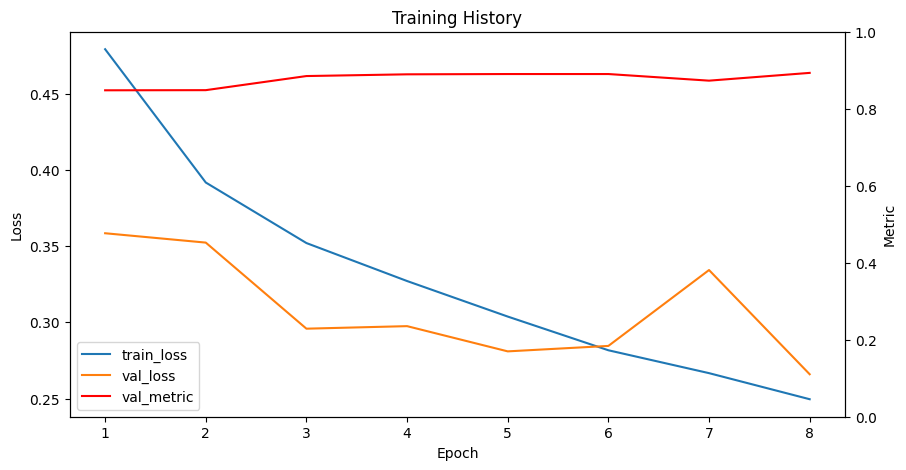

In [19]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs, metric, color='red', label='val_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

In [16]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2, mixed = False):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, half_precision=mixed)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [5]:
save_model(model,"ProtTans/PT5_GB1_finetuned_4.pth")

NameError: name 'model' is not defined

In [17]:
tokenizer, model = load_model("ProtTans/PT5_GB1_finetuned_3.pth")

/home/raylab/anaconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ImportError: 
T5Tokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [22]:
len(list(my_valid['label']))

2675

In [23]:
print(my_test.head(5))
len(list(my_test['sequence'])[1])

                                                sequence  label
5058   TVTLDESGGGLQTPGGGLSLVCKASGFTFSSYCMQWVRQAPGKGLE...      1
3137   QVTLRESGPALVKPTQTLTLTCTFSGFSLSTSGMCVSWIRQPPGKA...      1
64942  QVQLQESGPGLVKPSETLSLTCAVSGYSISSGHYWTWIRQPPGKGL...      0
1361   QVQLVQSGTEVKKPGESLTISCKTSGYYFTTYWITWVRQMPGKGLE...      1
40568  GGVVQPGRSLSLSCAASGFTFNFYGMHWVRQAPGKGLEWVANVWYD...      0


126

In [24]:
# Preprocess sequences
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)

In [25]:
print(my_test.head(5))

                                                sequence  label
5058   T V T L D E S G G G L Q T P G G G L S L V C K ...      1
3137   Q V T L R E S G P A L V K P T Q T L T L T C T ...      1
64942  Q V Q L Q E S G P G L V K P S E T L S L T C A ...      0
1361   Q V Q L V Q S G T E V K K P G E S L T I S C K ...      1
40568  G G V V Q P G R S L S L S C A A S G F T F N F ...      0


In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create Dataset
test_set = create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
predictions_raw = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions_raw += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|█████████████████████████████████████████| 168/168 [01:28<00:00,  1.89it/s]


In [35]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probabilities = sigmoid(np.array(predictions_raw))
probabilities

array([[0.41560689, 0.57140697],
       [0.19232087, 0.82213557],
       [0.91772964, 0.07390675],
       ...,
       [0.2335781 , 0.76941144],
       [0.45568336, 0.52832918],
       [0.93557883, 0.05795541]])

In [27]:
# Regression
# print(stats.spearmanr(a=predictions, b=my_test.label, axis=0))

# Classification
# we need to determine the prediction class from the logit output
predictions= [item.argmax() for item in np.array(predictions_raw)]
print("Accuracy: ", accuracy_score(my_test.label, predictions))

Accuracy:  0.8807922272047832


/home/raylab/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/raylab/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/raylab/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/raylab/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

In [28]:
my_test

,sequence,label
5058,T V T L D E S G G G L Q T P G G G L S L V C K ...,1
3137,Q V T L R E S G P A L V K P T Q T L T L T C T ...,1
64942,Q V Q L Q E S G P G L V K P S E T L S L T C A ...,0
1361,Q V Q L V Q S G T E V K K P G E S L T I S C K ...,1
40568,G G V V Q P G R S L S L S C A A S G F T F N F ...,0
...,...,...
120812,Q V Q L V Q S G A E V K K P G A S V K V S C K ...,0
2914,E V Q L Q Q S G A E L V R P G A S V K L S C T ...,1
122633,E V Q L L E S G G A L L Q P G G S L R L S C A ...,0
4330,Q V Q L V Q S G A E V K K P G A S V K V S C K ...,1


In [29]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Convert predictions and ground truth labels to numpy arrays
predicted_labels = np.array(predictions)
true_labels = np.array(my_test['label'])

# Compute ROC AUC
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report (precision, recall, F1-score)
class_report = classification_report(true_labels, predicted_labels)

# Print classification report
print("\nClassification Report:")
print(class_report)

# Print ROC AUC
print("\nROC AUC:", roc_auc)


Confusion Matrix:
[[1256  233]
 [  86 1101]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1489
           1       0.83      0.93      0.87      1187

    accuracy                           0.88      2676
   macro avg       0.88      0.89      0.88      2676
weighted avg       0.89      0.88      0.88      2676


ROC AUC: 0.8855337909058453


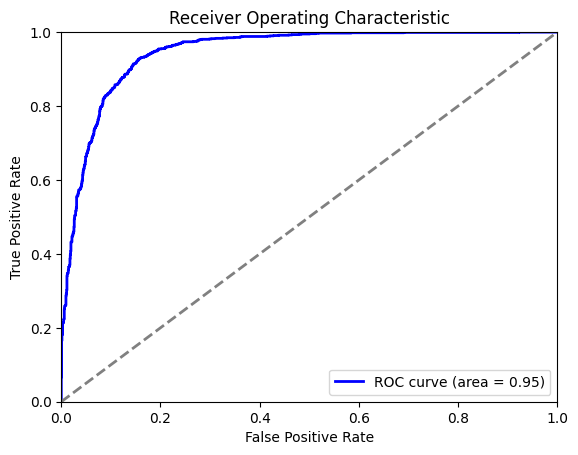

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming 'my_test.label' contains the true labels
roc_auc = roc_auc_score(true_labels, probabilities[:, 1])
fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [39]:
bcr = pd.read_csv('BCR/airr_rearrangement.tsv', sep='\t')
bcr.shape

(729, 41)

In [40]:
heavy_chains = bcr.dropna(subset=['acdr3']).copy()
heavy_chains.shape
heavy_chains["sequence_aa"]=heavy_chains["sequence_aa"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
heavy_chains['sequence_aa']=heavy_chains.apply(lambda row : " ".join(row["sequence_aa"]), axis = 1)
heavy_chains.shape

(310, 41)

In [50]:
# Function to get embeddings
def get_embeddings(dataloader, model, device):
    model.eval()
    model.to(device)
    embeddings_list = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items()}  # Move all inputs to the same device
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states  # Access hidden states
            # Use the last layer's hidden state mean as sequence embedding
            embeddings = hidden_states[-1].mean(dim=1).cpu().numpy()
            embeddings_list.append(embeddings)
    
    return np.vstack(embeddings_list)

embeddings = get_embeddings(test_dataloader, model, device)

In [52]:
embeddings.shape

(2676, 1024)

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f837ef79b20>
Traceback (most recent call last):
  File "/home/raylab/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/raylab/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/raylab/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/raylab/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

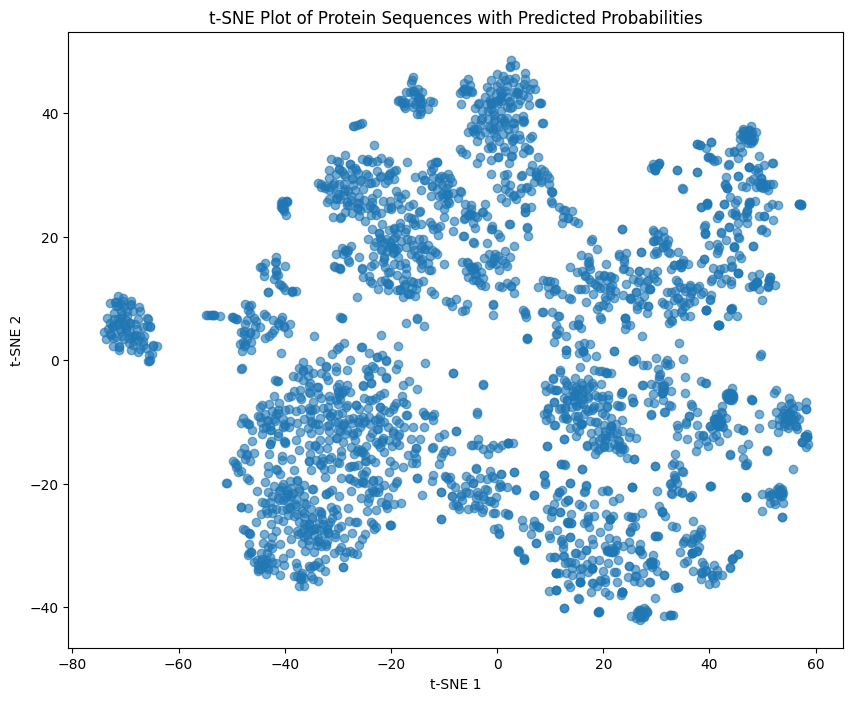

In [56]:
# Plotting the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6)
# plt.colorbar(label='Predicted Probability')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Plot of Protein Sequences with Predicted Probabilities')
plt.show()

In [16]:
model.to(device)

# Create a list to store the predictions
predicted_labels = []
predicted_probabilities = []
# Iterate through each sequence in the DataFrame
for sequence in heavy_chains['sequence_aa']:
    # Tokenize the sequence using the tokenizer
    encoded_sequence = tokenizer.encode_plus(sequence, return_tensors="pt", max_length=256, truncation=True)
    
    # Move the input tensors to the appropriate device
    input_ids = encoded_sequence['input_ids'].to(device)
    attention_mask = encoded_sequence['attention_mask'].to(device)
    
    # Make predictions for the current sequence
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits

    # Softmax to get probabilities
    probability = torch.softmax(logits, dim=1).squeeze().tolist()[1]
    
    # Take the argmax to get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()
    
    # Append the predicted label to the list of predictions
    predicted_labels.append(predicted_label)
    predicted_probabilities.append(probability)

# Add the list of predictions as a new column in the DataFrame
heavy_chains['predicted_label'] = predicted_labels
heavy_chains['predicted_probability'] = predicted_probabilities

In [33]:
# Sort the DataFrame based on the maximum predicted probability in each list
heavy_chains_sorted = heavy_chains.sort_values(by='predicted_probability', ascending=False)

# Reset the index after sorting
heavy_chains_sorted.reset_index(drop=True, inplace=True)
heavy_chains_sorted.head(100)

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label,predicted_probability
0,karen_0_290,CGCCAAGAGTTGCAGG-1,clonotype279,ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...,M K C S W V I F F L M A V V T G V N S E V Q L ...,T,F,IGHV14-3,48S351M281S,NaN,...,8,8,14,GFNIKDTY,IDPANGNT,ARSYYGYYYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.463120
1,karen_0_520,GGTGTTAAGAGTCGGT-1,clonotype301,TGGGACATACCAGCAAGGGAGTGACCAGTTAGTCTTAAGGCACCAC...,M A W V W T L L F L M A A A Q S I Q A Q I Q L ...,T,F,IGHV9-1,67S351M284S,IGHD2-8,...,8,8,15,GYTFTDYS,INTETGEP,APFYYGNYVYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.461667
2,karen_0_650,TCTTCGGCAGCTATTG-1,clonotype194,TGGGGAAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAA...,M A W V W T L L F L M A A A Q S I Q A Q I Q L ...,T,F,IGHV9-1,58S351M272S,IGHD1-1,...,8,8,11,GYTFTDYS,INTETGEP,AVITTVVATDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.458407
3,karen_0_469,GCTCTGTGTTAGTGGG-1,clonotype28,TGGGACAACATATGTCCAATGTCCTCTCCTCAGACACTGAACACAC...,M G W S W I F L F L L S G T A G V L S E V Q L ...,T,F,IGHV1-22,57S351M278S,IGHD2-3,...,8,8,13,GYTFTEYT,INPNNGGT,ARCYDGYDWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.445069
4,karen_0_101,AGCGGTCAGCAGCGTA-1,clonotype302,TGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTCAGTGA...,M N F G L S L I F L V L V L K G V Q C E V Q L ...,T,F,IGHV5-4,72S353M282S,NaN,...,8,8,15,GFTFSDYY,ISDGGSYT,ARDLDSSLLRSLFAY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.435035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,karen_0_117,AGGCCGTCAGCCTGTG-1,clonotype242,AATGGCTTATATGGGGACAGACGCACAACCCTGGACTCACAAGTCT...,M Y L G L N C V F I V F L L K G V Q S E V K L ...,T,F,IGHV6-6,84S357M269S,NaN,...,8,10,10,GFTFSNYW,IRLKSNNYAT,TRDDYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.334534
96,karen_0_409,GACTGCGAGCTACCGC-1,clonotype295,TGGGGAACATATGTCCAATGTCCTCTCCACAGTCCCTGAAGACACT...,M G W T W I F I L I L S V T T G V H S E V Q L ...,T,F,IGHV1-42,56S351M281S,NaN,...,8,8,14,GYSFTGYN,IDPYYGGT,ARSYYGEAYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.333759
97,karen_0_325,CGTTGGGGTTGTTTGG-1,clonotype218,CGTTGGGGTTGTTTGGCATTGATGAATTTTCGTATCTGGGGATGAG...,M K C S W V I F F L M A V V T G V N S E V Q L ...,T,F,IGHV14-4,87S351M275S,NaN,...,8,8,12,GFNIKDYY,IDPENGNT,ARSMMIRYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.332635
98,karen_0_4,AAACGGGTCGAACGGA-1,clonotype4,TGGGGAACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACT...,M G W S W I F L F L L S G T A G V H S E V Q L ...,T,F,IGHV1-26,56S351M260S,NaN,...,8,8,7,GYSFTGYT,INPYNGGT,ASSSFDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.332363


In [ ]:
plt.hist(heavy_chains['predicted_probability'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Predicted Probability')
plt.show()


In [27]:
candidates = heavy_chains_sorted.head(100).copy()
candidates.tail()

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label,predicted_probability
95,karen_0_637,TCGGGACCACCAGGCT-1,clonotype226,TGGGGAACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACT...,M G W S W I F L F L L S G T A G V L S E V Q L ...,T,F,IGHV1-22,56S351M275S,NaN,...,8,8,12,GYTFTEYT,INPNNGGT,AGTEAYYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.465772
96,karen_0_330,CTCACACGTTCCGTCT-1,clonotype234,GGGAGAAAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCAC...,M G W S Y I I L F L V A T A T D V H S Q V Q L ...,T,F,IGHV1-53,59S351M275S,NaN,...,8,8,12,GYTFTSYW,INPSNGRT,ARELRSYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.465611
97,karen_0_531,GTAACTGCATCACAAC-1,clonotype247,AGACATAGGAGCTTGGCTCTGGTTCCCAAGACCTCTCACTCACTTC...,M E W E L S L I F I F A L L K D V Q C E V Q L ...,T,F,IGHV11-2,51S353M273S,IGHD2-3,...,8,8,12,GFTFSGFW,INSDGSAI,MRYDGYYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.464976
98,karen_0_486,GGAACTTGTGAAGGCT-1,clonotype289,ATCTGGGGACAGTCATTGAAAACACTGACTCTAATCATGGAATGTA...,M E C N W I L P F I L S V I S G V Y S E V Q L ...,T,F,IGHV1-5,36S351M281S,NaN,...,8,8,14,GYSFTSYW,IYPGNSDT,TRRDRYGGGYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.462837
99,karen_0_204,CACACAATCTTGTACT-1,clonotype182,GAGATTCTCATTCAGTGATCAACACTGAACACACATCCCTTACCAT...,M D F G L I F F I V A L L K G V Q C E V K L L ...,T,F,IGHV4-1,44S350M270S,IGHD3-2,...,8,8,11,GFDFSRYW,INPGSSTI,ARLDSSGYFDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.462382


In [28]:
import re
candidates['sequence_aa'] = candidates['sequence_aa'].apply(lambda x: re.sub(r'\s+', '', x))

In [29]:
candidates

,sequence_id,cell_id,clone_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,ncdr1,ncdr2,ncdr3,acdr1,acdr2,acdr3,dataset_name,dataset_subgroup,predicted_label,predicted_probability
0,karen_0_568,GTTCGGGAGGTGGGTT-1,clonotype204,GACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGCCATGG...,MGWSCIIFFLVATATGVHSQVQLQQSGPEVVRPGVSVKISCKGSGY...,T,F,IGHV1-64,42S351M272S,IGHD1-1,...,8,8,11,GYTFTDYA,ISTYNGNT,AVITTVVATDY,karen,home_interclone_interclone_work_Interclone_kar...,1,0.625431
1,karen_0_517,GGTGAAGCAGGGCATA-1,clonotype316,GGGAACCTATGATCAGTATCCTCTCCACAGTCCCTGAACACACTGA...,MEWSWVFLFLLSLTSGVHSHVQLQQSGPELVRPGASVKLSCKASGY...,T,F,IGHV1-56,54S351M287S,NaN,...,8,8,16,GYIFITYW,IFPASGST,ARGGYYYGSHYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,1,0.596786
2,karen_0_598,TAGTTGGTCTTAGCCC-1,clonotype328,GATGGGGGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATT...,MSTEHRHLTMNFGFSLIFLVLVLKGVQCEVKLVESGGGLVKPGGSL...,T,F,IGHV5-9-1,51S248M3D129M282S,NaN,...,8,7,15,GFTFSSYA,ISSGGST,ARGATVVAFYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,1,0.579385
3,karen_0_308,CGTCACTAGGAACTGC-1,clonotype294,TGGGGATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGG...,MAVLVLFLCLVAFPSCVLSQVQLKESGPGLVAPSQSLSITCTVSGF...,T,F,IGHV2-9,33S350M282S,NaN,...,8,7,15,GFSLTSYG,IWAGGST,ARGPPLLSGTTPLDY,karen,home_interclone_interclone_work_Interclone_kar...,1,0.577610
4,karen_0_682,TGTCCCATCGTCCAGG-1,clonotype85,TGGGGATATCTCTCACTGGAGCGTGATCTCTGAAGGAAGGAGGTGT...,MRVLILVYLLTVLPGILSDVQLQESGPGLVKPSQTVSLTCTVTGYS...,T,F,IGHV3-4,56S353M255S,NaN,...,10,7,6,GYSITNGNHW,ISSSGST,ARDWDY,karen,home_interclone_interclone_work_Interclone_kar...,1,0.576731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,karen_0_637,TCGGGACCACCAGGCT-1,clonotype226,TGGGGAACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACT...,MGWSWIFLFLLSGTAGVLSEVQLQQSGPELVKPGASVKISCKTSGY...,T,F,IGHV1-22,56S351M275S,NaN,...,8,8,12,GYTFTEYT,INPNNGGT,AGTEAYYYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.465772
96,karen_0_330,CTCACACGTTCCGTCT-1,clonotype234,GGGAGAAAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCAC...,MGWSYIILFLVATATDVHSQVQLQQPGAELVKPGASVKLSCKASGY...,T,F,IGHV1-53,59S351M275S,NaN,...,8,8,12,GYTFTSYW,INPSNGRT,ARELRSYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.465611
97,karen_0_531,GTAACTGCATCACAAC-1,clonotype247,AGACATAGGAGCTTGGCTCTGGTTCCCAAGACCTCTCACTCACTTC...,MEWELSLIFIFALLKDVQCEVQLLETGGGLVQPGGSRGLSCEGSGF...,T,F,IGHV11-2,51S353M273S,IGHD2-3,...,8,8,12,GFTFSGFW,INSDGSAI,MRYDGYYWYFDV,karen,home_interclone_interclone_work_Interclone_kar...,0,0.464976
98,karen_0_486,GGAACTTGTGAAGGCT-1,clonotype289,ATCTGGGGACAGTCATTGAAAACACTGACTCTAATCATGGAATGTA...,MECNWILPFILSVISGVYSEVQLQQSGTVLARPGASVKMSCKASGY...,T,F,IGHV1-5,36S351M281S,NaN,...,8,8,14,GYSFTSYW,IYPGNSDT,TRRDRYGGGYAMDY,karen,home_interclone_interclone_work_Interclone_kar...,0,0.462837


In [30]:
# candidates.to_csv('BCR/candidates.csv')

In [31]:
model.config

T5Config {
  "_name_or_path": "Rostlab/prot_t5_xl_uniref50",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.32.1",
  "use_cache": true,
  "vocab_size": 128
}